In [4]:
import ee
%matplotlib inline
import math
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import datetime, calendar

plt.style.use("seaborn-darkgrid")

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1Adeu5BXcKJ7HxFMojDI9Z9rO2TaYEGxe-G153doWYKIcwbov-wsHNTxIRZ8

Successfully saved authorization token.


In [111]:
MODEL_INFO = {'UKESM1-0-LL': 'HadAM',
 'NorESM2-MM': 'CCM',
 'NorESM2-LM': 'CCM',
 'MRI-ESM2-0': 'UCLA GCM',
 'MPI-ESM1-2-LR': 'ECMWF',
 'MPI-ESM1-2-HR': 'ECMWF',
 'MIROC6': 'MIROC',
 'MIROC-ES2L': 'MIROC',
 'KIOST-ESM': 'GFDL',
 'KACE-1-0-G': 'HadAM',
 'IPSL-CM6A-LR': 'IPSL',
 'INM-CM5-0': 'INM',
 'INM-CM4-8': 'INM',
 'HadGEM3-GC31-MM': 'HadAM',
 'HadGEM3-GC31-LL': 'HadAM',
 'GFDL-ESM4': 'GFDL',
 'GFDL-CM4_gr2': 'GFDL',
 'GFDL-CM4': 'GFDL',
 'FGOALS-g3': 'CCM',
 'EC-Earth3-Veg-LR': 'ECMWF',
 'EC-Earth3': 'ECMWF',
 'CanESM5': 'CanAM',
 'CNRM-ESM2-1': 'ECMWF',
 'CNRM-CM6-1': 'ECMWF',
 'CMCC-ESM2': 'CCM',
 'CMCC-CM2-SR5': 'CCM',
 'BCC-CSM2-MR': 'CCM',
 'ACCESS-ESM1-5': 'HadAM',
 'ACCESS-CM2': 'HadAM',
 'TaiESM1': 'CCM',
}

EXCLUDED_MODELS = ['GFDL-CM4_gr2','ERA5']    # TaiESM1 model has major known biases

MODELS = [i for i in MODEL_INFO.keys() if not i in EXCLUDED_MODELS]

SEASONS = [
    ('12-01', '02-28'),
    ('03-01'), ('05-31'),
    ('06-01'), ('08-31'),
    ('09-01'), ('11-30')
]

INITIAL_LATLON = (-1.286389, 36.817223)  # Nairobi
#INITIAL_LATLON = (-28.283665532, -52.784830194) #  Carazinho
INITIAL_WINDOW = ('04-15', '11-30')

HIST_START = 1980
HIST_END = 2014
FUTURE_START = 2050
FUTURE_END = 2070

STUDY_THRESH = 40

NUM_BEST_MODELS = 3

shift_years = INITIAL_LATLON[0] < 0

In [56]:
def d2j(datestring):
    d = datetime.date.fromisoformat(datestring)
    jday = d.timetuple().tm_yday
    if calendar.isleap(d.year) and jday > 59:
        jday -= 1
    return jday

In [57]:
def runs(tf_array, min_runsize, result_type=None):
    falses = np.zeros(tf_array.shape[0]).reshape((tf_array.shape[0],1))
    extended_a = np.concatenate((falses, tf_array, falses), axis=1)
    df = np.diff((extended_a), axis=1)
    starts = np.nonzero(df == 1)
    ends = np.nonzero(df == -1)
    lengths = {i: [] for i in range(tf_array.shape[0] + 1)}
    indices = {i: [] for i in range(tf_array.shape[0] + 1)}
    if starts[0].size > 0:
        for idx in range(starts[0].size):
            length = ends[1][idx] - starts[1][idx]
            if length >= min_runsize:
                lengths[starts[0][idx]].append(ends[1][idx] - starts[1][idx])
                indices[starts[0][idx]].append((ends[1][idx], starts[1][idx]))
        lengths_vals = lengths.values()
    else:
        lengths_vals = []
    result = []
    
    if result_type == 'maxlength':
        for ll in lengths.values():
            if ll:
                result.append(np.max(ll))
            else:
                result.append(0)
    elif result_type == 'minlength':
        for ll in lengths.values():
            if ll:
                result.append(np.min(ll))
            else:
                result.append(0)
    elif result_type == 'meanlength':
        for ll in lengths.values():
            if ll:
                result.append(np.mean(ll))
            else:
                result.append(0)
    elif result_type == 'medianlength':
        for ll in lengths.values():
            if ll:
                result.append(np.median(ll))
            else:
                result.append(0)
    elif result_type == 'count':
        for ll in lengths.values():
            if ll:
                result.append(len(ll))
            else:
                result.append(0)
    elif result_type == 'indices':
        result = indices
    else:
        result = lengths
    
    return result

In [58]:
def get_var(varname, model, latlon, start_year=HIST_START, end_year=HIST_END, yearshift=False, scenario='ssp585'):
    def removeLeapDays(arr, yearshift=False):
        if not yearshift:
            indices = []
            jan1_idx = 0
            for year in range(start_year, end_year+1):
                indices += [jan1_idx + i for i in range(365)]
                jan1_idx += 365
                if calendar.isleap(year):
                    jan1_idx += 1
            return arr[indices]
        else:
            indices = []
            jul1_idx = 0
            for year in range(start_year-1, end_year):
                indices += [jul1_idx + i for i in range(183)]
                jul1_idx += 183
                if calendar.isleap(year):
                    jul1_idx += 1
                indices += [jul1_idx + i for i in range(182)]
                jul1_idx += 182
            return arr[indices]
    if model != 'ERA5' and start_year < 2015 and end_year >= 2015:
        raise Exception("Requesting hist and non-hist variables in one query")
    if model == 'ERA5':
        dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
    else:
        dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model)).filter(ee.Filter.eq('scenario', [scenario, 'historical'][int(end_year<2015)]))
    gee_geom = ee.Geometry.Point((latlon[1], latlon[0]))
    if not yearshift:
        data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-01-01'.format(start_year), '{0}-01-01'.format(end_year+ 1)))
        result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        return removeLeapDays(np.array(result), False)
    else:
        data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-07-01'.format(start_year-1), '{0}-07-01'.format(end_year)))
        result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        return removeLeapDays(np.array(result), True)

In [59]:
def get_rmsd(d1, d2):
    def seasonal_means(d):
        mam = []  # 60-151
        jja = []  # 152-243
        son = []  # 244-334
        djf = []  # 335-59
        jan1_idx = 365 + [0, 1][int(calendar.isleap(HIST_START))]
        for year in range(HIST_START, HIST_END):
            mam.append(d[jan1_idx + 60 : jan1_idx + 152])
            jja.append(d[jan1_idx + 152 : jan1_idx + 244])
            son.append(d[jan1_idx + 244 : jan1_idx + 335])
            if year < HIST_END - 1:
                if calendar.isleap(year) and False:
                    yearlength = 366
                else:
                    yearlength = 365
                djf.append(np.concatenate((d[jan1_idx + 335 : jan1_idx + 365], d[jan1_idx + yearlength : jan1_idx + yearlength + 60])))
            else:
                djf.append(np.concatenate((d[335 : 365], d[365 + [0, 1][int(False and calendar.isleap(HIST_START-1))] : 425])))
            jan1_idx += 365 + [0, 1][int(False and calendar.isleap(year))]
        return np.array([np.mean(mam, axis=1), np.mean(jja, axis=1), np.mean(son, axis=1), np.mean(djf, axis=1)]).flatten()
            
    c1 = seasonal_means(d1)
    c2 = seasonal_means(d2)
    return np.sqrt(np.mean(np.sum((c1 - c2)**2)))

In [101]:
def seasonal_means(d):
    def the_seasonal_means(d):
        mam = []  # 60-151
        jja = []  # 152-243
        son = []  # 244-334
        djf = []  # 335-59
        jan1_idx = 365 + [0, 1][int(calendar.isleap(HIST_START))]
        for year in range(HIST_START, HIST_END):
            mam.append(d[jan1_idx + 60 : jan1_idx + 152])
            jja.append(d[jan1_idx + 152 : jan1_idx + 244])
            son.append(d[jan1_idx + 244 : jan1_idx + 335])
            if year < HIST_END - 1:
                if calendar.isleap(year) and False:
                    yearlength = 366
                else:
                    yearlength = 365
                djf.append(np.concatenate((d[jan1_idx + 335 : jan1_idx + 365], d[jan1_idx + yearlength : jan1_idx + yearlength + 60])))
            else:
                djf.append(np.concatenate((d[335 : 365], d[365 + [0, 1][int(False and calendar.isleap(HIST_START-1))] : 425])))
            jan1_idx += 365 + [0, 1][int(False and calendar.isleap(year))]
        return np.array([np.mean(mam, axis=1), np.mean(jja, axis=1), np.mean(son, axis=1), np.mean(djf, axis=1)])

    return the_seasonal_means(d)

In [60]:
def calibration_function(hist_obs, hist_mod):
    source = np.sort(hist_obs.flatten())
    target= np.sort(hist_mod.flatten())
    if (np.max(source) == 0 and np.min(source) == 0):
        return np.arange(0, target.size) / target.size
    if (np.max(target) == 0 and np.min(target) == 0):
        return np.arange(0, source.size) / source.size
    new_indices = []
    #source[-1] = target[-1]  # when target[i] greater than all source values, return max index
    for target_idx, target_value in enumerate(target):
        if target_idx < len(source):
            source_value = source[target_idx]
            if source_value > target[-1]:
                new_indices.append(target.size - 1)
            else:
                new_indices.append(np.argmax(target >= source_value))
    return np.array(new_indices) / source.size

In [112]:
# Select three best models based on RMSD of quarterly mean precip
hist_obs = get_var('total_precipitation', 'ERA5', INITIAL_LATLON, yearshift=shift_years)
hist_mods = {}
rmsds = []
for model in MODELS:
    hist_mod = get_var('pr', model, INITIAL_LATLON, start_year=HIST_START)
    hist_mods[model] = hist_mod
    rmsds.append((get_rmsd(hist_obs, hist_mod), model))
rmsds.sort()
best_models = []
families = []
idx = 0
while len(best_models) < 3:
    if not MODEL_INFO[rmsds[idx][1]] in families:
        best_models.append(rmsds[idx][1])
        families.append(MODEL_INFO[rmsds[idx][1]])
    idx += 1
    
for m in best_models:
    print(m, [i[0] for i in rmsds if i[1]==m][0])

MRI-ESM2-0 0.02633837187842554
INM-CM4-8 0.026346474488370967
KIOST-ESM 0.02634930120518674


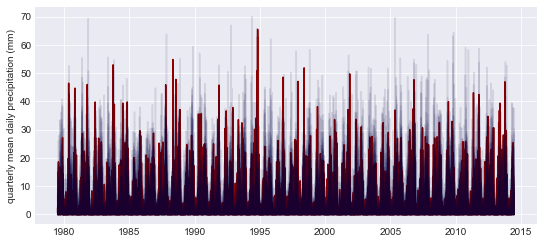

In [95]:
plt.figure(figsize=(9,4))
plt.ylabel('quarterly mean daily precipitation (mm)')
for model in hist_mods:
    plt.plot([HIST_START + ((i - [0, 182][int(shift_years)])/365) for i in list(range(len(hist_obs)))], hist_mods[model] * 86400, color=['#000040', '#900000'][int(model in best_models)], alpha=[0.1, 1][int(model in best_models)])
#plt.plot([HIST_START + ((i - [0, 182][int(shift_years)])/365) for i in list(range(len(hist_obs)))], hist_obs * 1000, color="#ffff00")
plt.show()

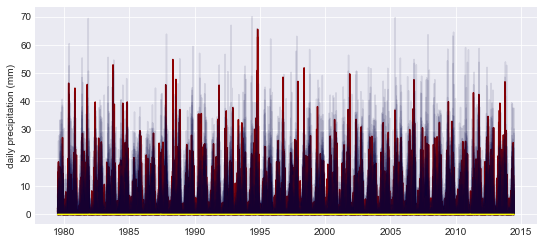

In [113]:
plt.figure(figsize=(9,4))
plt.ylabel('daily precipitation (mm)')
for model in hist_mods:
    plt.plot([HIST_START + ((i - [0, 182][int(shift_years)])/365) for i in list(range(len(hist_obs)))], hist_mods[model] * 86400, color=['#000040', '#900000'][int(model in best_models)], alpha=[0.1, 1][int(model in best_models)])
plt.plot([HIST_START + ((i - [0, 182][int(shift_years)])/365) for i in list(range(len(hist_obs)))], hist_obs * 1, color="#ffff00")
plt.show()

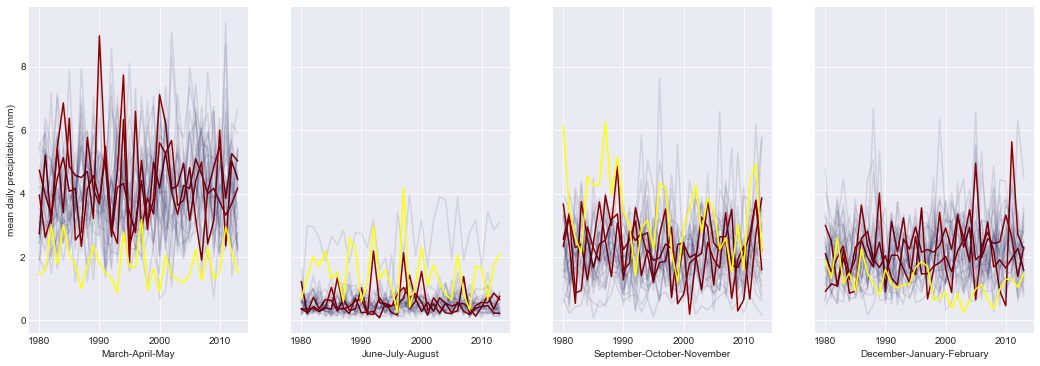

<Figure size 648x288 with 0 Axes>

In [115]:
fig, (mam, jja, son, djf) = plt.subplots(1, 4, sharey=True, figsize=(18, 6))
plt.figure(figsize=(9,4))
for season in range(4):
    ax = [mam, jja, son, djf][season]
    for model in hist_mods:
        ax.plot([HIST_START + i for i in range(HIST_END - HIST_START)], seasonal_means(hist_mods[model] * 86400)[season], color=['#000040', '#900000'][int(model in best_models)], alpha=[0.1, 1][int(model in best_models)])
    ax.plot([HIST_START + i for i in range(HIST_END - HIST_START)], seasonal_means(hist_obs * 1000)[season], color="#ffff00")
    if season == 0:
        ax.set_ylabel('mean daily precipitation (mm)')
    ax.set_xlabel(['March-April-May', 'June-July-August', 'September-October-November', 'December-January-February'][season])
        #plt.xlabel('modeled')
    #plt.legend()


In [104]:
seasonal_means(hist_mods[model] * 86400)

array([[4.21927493, 4.10021598, 3.92053132, 4.00980165, 3.37918289,
        7.87699023, 3.72950242, 2.1917385 , 3.39473714, 2.79395151,
        2.66846124, 4.50730574, 7.05448745, 4.51613312, 3.92241806,
        2.58307244, 3.75981909, 4.86526037, 4.19303096, 3.58116258,
        3.105749  , 6.41488498, 4.06571274, 4.1997478 , 4.25010049,
        3.68041631, 4.98595485, 2.50373642, 2.45606222, 5.16397533,
        2.90814806, 6.1323784 , 3.70962642, 5.38497298],
       [0.67047403, 0.29852668, 0.81537689, 0.50643232, 0.40622589,
        0.34962343, 0.41822866, 0.37062037, 0.22209499, 0.16132817,
        0.57565852, 0.14898343, 0.18930863, 1.09543597, 0.19037521,
        0.89812949, 0.84795925, 0.26208755, 1.18623819, 0.49747743,
        0.42420384, 0.24848756, 0.25966057, 0.30252256, 0.24718239,
        0.24530206, 0.80401701, 0.1609498 , 0.83625999, 0.37434558,
        0.23113367, 0.27723121, 0.38560579, 0.23359329],
       [2.04581713, 0.38719612, 3.3242147 , 2.6201433 , 2.03110772,
  

In [100]:
seasonal_means(hist_obs * 1)

array([[6.05821846, 3.44472295, 2.57868647, 2.11461807, 4.49079218,
        4.25482035, 4.40675879, 6.18637719, 3.92910276, 5.1133056 ,
        3.41195278, 2.98845251, 1.39758917, 2.90402741, 3.13504981,
        2.22888952, 4.28536248, 4.15455504, 2.16029474, 1.20192145,
        2.92411974, 3.47828688, 4.23319184, 2.734887  , 3.82958615,
        3.44874394, 2.21612995, 2.555028  , 1.55465591, 3.00532279,
        1.57672297, 4.33261075, 4.88956436, 2.15434194],
       [1.868686  , 1.29168739, 2.55511948, 1.15693372, 1.47199496,
        0.87296346, 2.04003849, 1.48746528, 1.29412115, 0.82871372,
        1.61457302, 1.13286193, 0.9929108 , 1.10110345, 1.11990535,
        1.66282898, 1.81514415, 1.65524268, 0.73557318, 0.66609803,
        0.88506781, 0.38587163, 0.82358887, 0.25168629, 0.59229574,
        0.98475675, 1.0959385 , 0.67602435, 0.33098696, 0.95819884,
        1.26873836, 1.2692173 , 1.02131968, 1.41252371],
       [1.60722831, 3.31000661, 1.82484537, 3.04545556, 2.09910462,
  

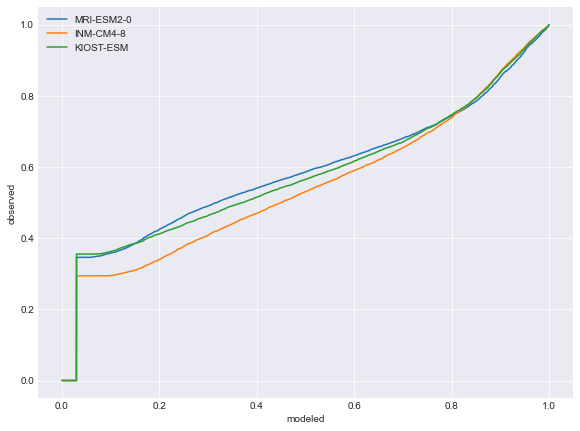

In [79]:
# Get precip calibration functions

calibration_fxn = {}
hist_mod = {}

hist_obs = get_var('total_precipitation', 'ERA5', INITIAL_LATLON) * 1000
plt.figure(figsize=(6.4*1.5, 4.8*1.5))
for model in best_models:
    hist_mod[model] = get_var('pr', model, INITIAL_LATLON, yearshift = shift_years) * 86400
    calibration_fxn[model] = calibration_function(hist_obs, hist_mod[model])
    plt.plot([j/(len(hist_obs)+1) for j in range(len(hist_obs))], calibration_fxn[model], label=model)
    plt.xlabel('modeled')
    plt.ylabel('observed')
    plt.legend()
plt.show()

In [75]:
o = hist_obs
o.sort()
o[:5000]

array([0.        , 0.        , 0.        , ..., 0.07841736, 0.07857382,
       0.07866323])

In [74]:
m = hist_mod['MPI-ESM1-2-HR']
m.sort()
m[:5000]

array([0.        , 0.        , 0.        , ..., 0.03900688, 0.03925688,
       0.0393358 ])

In [49]:
fut_mod = {}
for model in best_models:
    fut_mod[model] = get_var('pr', model, INITIAL_LATLON, start_year=FUTURE_START, end_year=FUTURE_END, yearshift=shift_years) * 86400

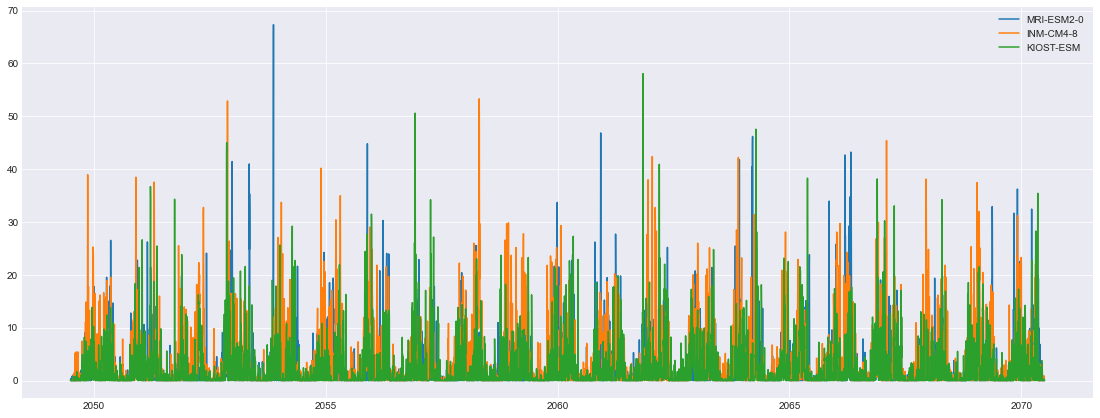

In [36]:
# Plot future modeled time series of precip

plt.figure(figsize=(6.4*3, 4.8*1.5))
for model in fut_mod:
    plt.plot([FUTURE_START + ((i - [0, 182][int(shift_years)])/365) for i in range(365*21)], fut_mod[model], label=model)
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 5 == 0])
plt.legend()
plt.show()

In [50]:
def calibrate(uncalibrated_data, calibration_fxn):
    N = len(uncalibrated_data)
    unsorted_uncalib = [(i, idx) for idx, i in enumerate(uncalibrated_data)]
    sorted_uncalib = sorted(unsorted_uncalib)
    result = [0] * N
    for j in range(N):
        X_j = j / (N + 1)
        Y_jprime = calibration_fxn[round(X_j * len(calibration_fxn))]
        jprime = math.floor(Y_jprime * N + 1)
        result[sorted_uncalib[j][1]] = sorted_uncalib[jprime][0]
    return result

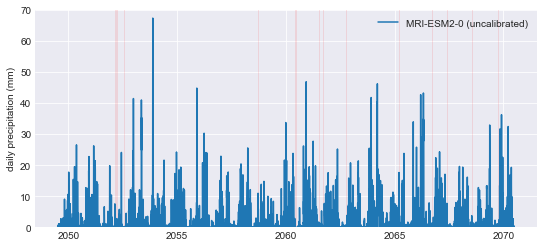

In [51]:
# Plot future modeled time series of UNCALIBRATED precip

plt.figure(figsize=(9,4))
for model in list(fut_mod.keys())[:1]:
    plt.plot([2050 + ((i - [0, 182][int(shift_years)])/365) for i in range(365*21)], fut_mod[model], label='{0} (uncalibrated)'.format(model))
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 5 == 0])
plt.ylim(0,70)
run_indices = runs(fut_mod[model].reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'indices')
for year_idx in run_indices:
    year = FUTURE_START + year_idx
    for ii in run_indices[year_idx]:
        if ii:
            plt.axvspan(year+((ii[1] - [0, 182][int(shift_years)])/365), year+((ii[0] - [0, 182][int(shift_years)])/365), facecolor='r', alpha=0.1)
#plt.text(2050, 60, '{0} dryspells lasting 15+ days during 2050-2070'.format(np.sum(runs(fut_mod[model].reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'count'))), fontsize=30)
plt.ylabel('daily precipitation (mm)')
plt.legend(loc='upper right')
plt.show()

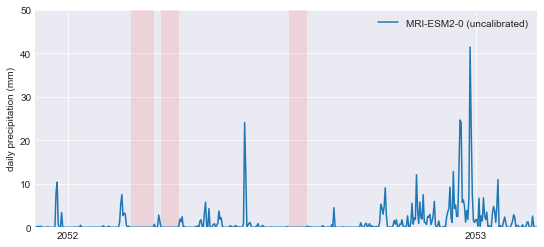

In [52]:
# Plot close-up
plt.figure(figsize=(9,4))
for model in list(fut_mod.keys())[:1]:
    plt.plot([2050 + ((i - [0, 182][int(shift_years)])/365) for i in range(365*21)], fut_mod[model], label='{0} (uncalibrated)'.format(model))
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 1 == 0])
plt.ylim(0,50)
plt.xlim(2050+(700/365),2050+(1150/365))
run_indices = runs(fut_mod[model].reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'indices')
for year_idx in run_indices:
    year = FUTURE_START + year_idx
    for ii in run_indices[year_idx]:
        if ii:
            plt.axvspan(year+((ii[1] - [0, 182][int(shift_years)])/365), year+((ii[0] - [0, 182][int(shift_years)])/365), facecolor='r', alpha=0.1)
#plt.text(2050, 60, '{0} dryspells lasting 15+ days during 2050-2070'.format(np.sum(runs(fut_mod[model].reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'count'))), fontsize=30)
plt.legend(loc='upper right')
plt.ylabel('daily precipitation (mm)')
plt.show()

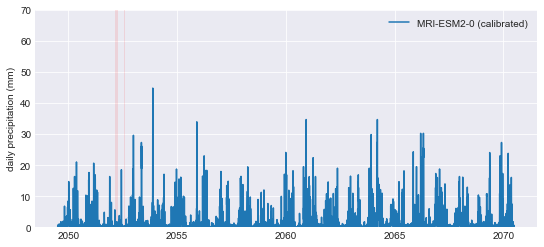

In [53]:
# Plot future modeled time series of CALIBRATED tasmax

plt.figure(figsize=(9,4))
for model in list(fut_mod.keys())[:1]:
    calib_data = np.array(calibrate(fut_mod[model], calibration_fxn[model]))
    plt.plot([2050 + ((i - [0, 182][int(shift_years)])/365) for i in range(365*21)], calib_data, label='{0} (calibrated)'.format(model))
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 5 == 0])
plt.ylim(0, 70)
#plt.xlim(2050+(750/365),2050+(900/365))
run_indices = runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'indices')
for year_idx in run_indices:
    year = 2050 + year_idx
    for ii in run_indices[year_idx]:
        if ii:
            plt.axvspan(year+((ii[1] - [0, 182][int(shift_years)])/365), year+((ii[0] - [0, 182][int(shift_years)])/365), facecolor='r', alpha=0.1)
#plt.text(2050, 60, '{0} dryspells lasting 15+ days during 2050-2070'.format(np.sum(runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'count'))), fontsize=30)
plt.legend(loc='upper right')
plt.ylabel('daily precipitation (mm)')
plt.show()

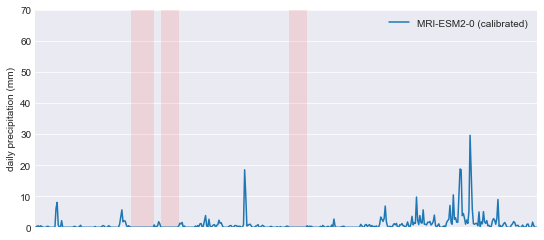

In [54]:
# Plot future modeled time series of CALIBRATED tasmax

plt.figure(figsize=(9,4))
for model in list(fut_mod.keys())[:1]:
    calib_data = np.array(calibrate(fut_mod[model], calibration_fxn[model]))
    plt.plot([2050 + ((i - [0, 182][int(shift_years)])/365) for i in range(365*21)], calib_data, label='{0} (calibrated)'.format(model))
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 5 == 0])
plt.ylim(0, 70)
plt.xlim(2050+(700/365),2050+(1150/365))
#plt.xlim(2050+(750/365),2050+(900/365))
run_indices = runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'indices')
for year_idx in run_indices:
    year = 2050 + year_idx
    for ii in run_indices[year_idx]:
        if ii:
            plt.axvspan(year+((ii[1] - [0, 182][int(shift_years)])/365), year+((ii[0] - [0, 182][int(shift_years)])/365), facecolor='r', alpha=0.1)
#plt.text(2050, 60, '{0} dryspells lasting 15+ days during 2050-2070'.format(np.sum(runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'count'))), fontsize=30)
plt.legend(loc='upper right')
plt.ylabel('daily precipitation (mm)')
plt.show()

In [137]:
for model in list(fut_mod.keys()):
    calib_data = np.array(calibrate(fut_mod[model], calibration_fxn[model]))
    a = np.sum(runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365)) * 86400 == 0, 15, 'count'))
    print(model, a)

MRI-ESM2-0 4
IPSL-CM6A-LR 6
HadGEM3-GC31-MM 1


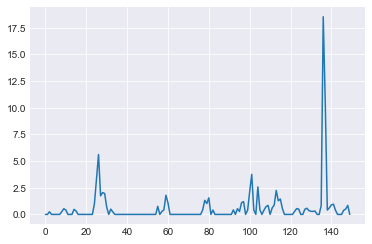

In [98]:
plt.plot(calib_data[750:900])

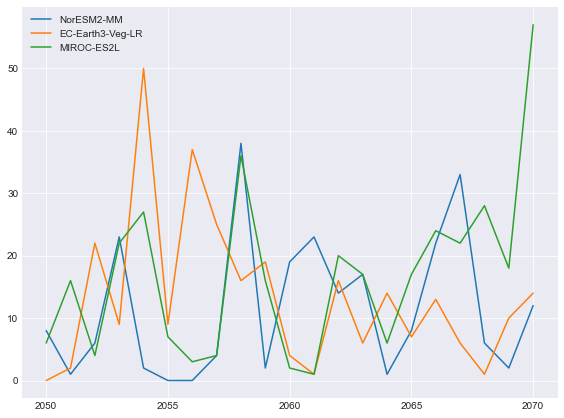

In [355]:
# Plot CALIBRATED future modeled time series of tasmax > STUDY_THRESH

plt.figure(figsize=(6.4*1.5, 4.8*1.5))
for model in fut_mod:
    rs = np.array(calibrate(fut_mod[model], calibration_fxn[model])).reshape((FUTURE_END-FUTURE_START+1, 365))
    counts = np.sum(rs>STUDY_THRESH+273.15, axis=1)
    plt.plot(range(FUTURE_START, FUTURE_END+1), counts, label=model)
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 5 == 0])
plt.legend()
plt.show()

In [128]:
def get_gamma(count, size):
    return np.random.gamma(shape = count + 0.5, size=size)

In [129]:
posterior_lambdas = {}
for model in fut_mod:
    calib_data = np.array(calibrate(fut_mod[model], calibration_fxn[model]))
    count = np.sum(runs(calib_data.reshape((FUTURE_END-FUTURE_START+1, 365))  == 0, 15, 'count'))
    posterior_lambdas[model] = get_gamma(count, 10000)

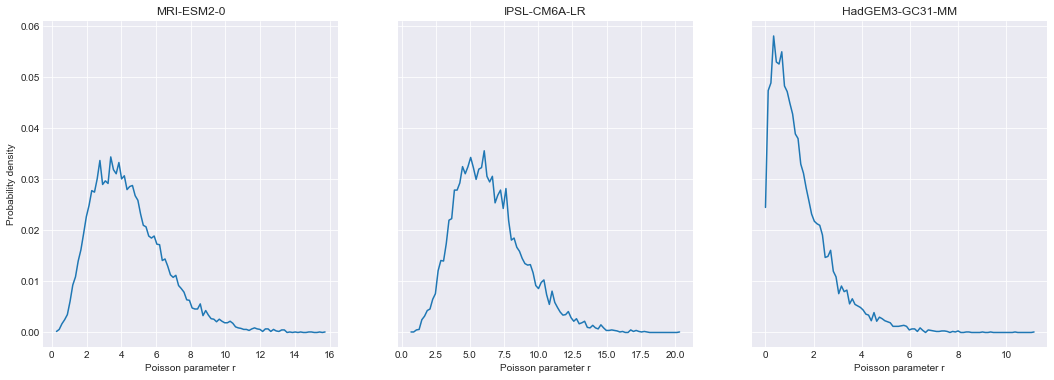

In [132]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
hist = np.histogram(posterior_lambdas[list(posterior_lambdas.keys())[0]], bins=100)
hist0 = ax0.plot(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax0.set_title(list(posterior_lambdas.keys())[0])
hist = np.histogram(posterior_lambdas[list(posterior_lambdas.keys())[1]], bins=100)
hist1 = ax1.plot(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax1.set_title(list(posterior_lambdas.keys())[1])
hist = np.histogram(posterior_lambdas[list(posterior_lambdas.keys())[2]], bins=100)
hist2 = ax2.plot(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax2.set_title(list(posterior_lambdas.keys())[2])
ax0.set_ylabel('Probability density')
ax0.set_xlabel('Poisson parameter r')
ax1.set_xlabel('Poisson parameter r')
ax2.set_xlabel('Poisson parameter r')
plt.show()

In [133]:
poisson_draws = {}
for model in posterior_lambdas:
    poisson_draws[model] = np.random.poisson(posterior_lambdas[model], 10000)

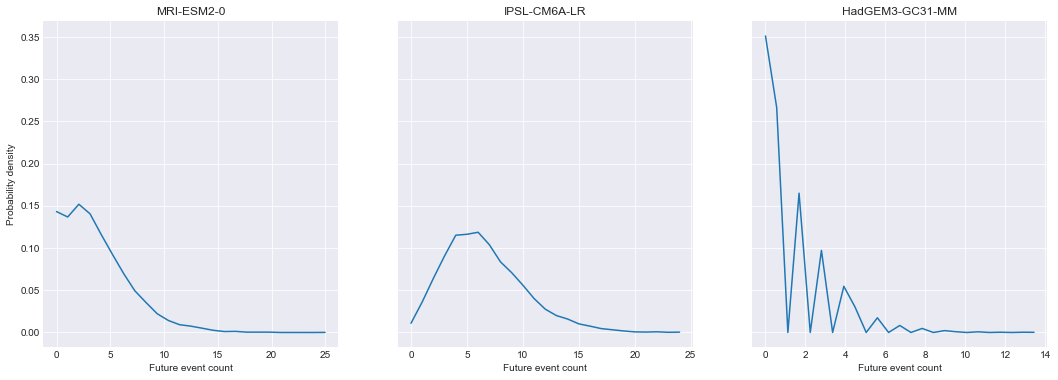

In [134]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
hist = np.histogram(poisson_draws[list(poisson_draws.keys())[0]], bins=25)
hist0 = ax0.plot(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax0.set_title(list(poisson_draws.keys())[0])
hist = np.histogram(poisson_draws[list(poisson_draws.keys())[1]], bins=25)
hist1 = ax1.plot(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax1.set_title(list(poisson_draws.keys())[1])
hist = np.histogram(poisson_draws[list(poisson_draws.keys())[2]], bins=25)
hist2 = ax2.plot(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax2.set_title(list(poisson_draws.keys())[2])
ax0.set_ylabel('Probability density')
ax0.set_xlabel('Future event count')
ax1.set_xlabel('Future event count')
ax2.set_xlabel('Future event count')
plt.show()

In [135]:
for model in poisson_draws:
    print('{0}: {1}'.format(model, np.sum(poisson_draws[model]) / 10000))

MRI-ESM2-0: 4.488
IPSL-CM6A-LR: 6.5404
HadGEM3-GC31-MM: 1.5067
